In [20]:
# Reference:
#    https://github.com/ebonilla/mtgp
#    https://proceedings.neurips.cc/paper/2007/file/66368270ffd51418ec58bd793f2d9b1b-Paper.pdf
#    https://gpflow.readthedocs.io/en/master/notebooks/advanced/coregionalisation.html
#    
#
import numpy as onp
np.set_printoptions(precision=3,suppress=True)
from sklearn.metrics import mean_squared_error

import jax
import jax.numpy as np
from jax import grad, jit, vmap, device_put, random

import matplotlib.pyplot as plt
import matplotlib as mpl
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.family'] = 'Times New Roman'
cmap = plt.cm.get_cmap('bwr')


from tabulate import tabulate

import sys
sys.path.append('../kernel')
from jaxkern import (cov_se, LookupKernel, normalize_K, mtgp_k)

from plt_utils import plt_savefig, plt_scaled_colobar_ax
from gp import gp_regression_chol, run_sgd, log_func_default
from gpax import *

In [14]:

## Parameters

M = 2
n_train = 50
n_test = 50
ylim = (-3,3)
xlim = (-.2,1.2)
σn = [.03, .1]
ℓ = .2
mtl = True
lr = .002
num_steps = 100
verbose = True
opt = 'sgd'


## Data
key = jax.random.PRNGKey(0)
onp.random.seed(0)

X0 = random.uniform(key, (n_train*2//4, 1)) # *.5+.5
X1 = random.uniform(key, (n_train-len(X0), 1))*.5
X_train = np.vstack((np.hstack((X0, np.zeros_like(X0))),
                     np.hstack((X1, np.ones_like(X1)))))

f0 = lambda X: np.sin(6*X)
f1 = lambda X: np.sin(6*X + 1)
fs = [f0,f1]
Y0 = f0(X0) + random.normal(key, X0.shape)*σn[0]
Y1 = f1(X1) + random.normal(key, X1.shape)*σn[1]
y_train = np.vstack((Y0,Y1))

X_test = np.vstack((np.tile(np.linspace(xlim[0], xlim[1], n_test), M),
                    np.hstack([t*np.ones(n_test) for t in range(M)]))).T


In [183]:

import flax
from flax.core import freeze, unfreeze
from flax import optim, struct
from flax import linen as nn


class CovIndex(nn.Module):
    """A kernel applied to indices over a lookup take B
            K[i,j] = B[i,j]
                where B = WWᵀ + diag[v]
    """
    # #rows of W
    output_dim: int
    # #columns of W
    rank: int

    def setup(self):
        self.W = self.param('W', lambda k,s: random.normal(k,s),
                             (self.output_dim, self.rank))
        self.v = BijSoftplus.forward(
            self.param('v', lambda k,s: np.ones(s), (self.output_dim)))

    def cov(self):
        return self.W@self.W.T + np.diag(self.v)

    def __call__(self, X, Y=None, full_cov=True):
        if full_cov:
            Y = X if Y is None else Y
            X = np.asarray(X[:,-1], np.int32).squeeze()
            Y = np.asarray(Y[:,-1], np.int32).squeeze()
            B = self.cov()
            K = np.take(np.take(B,Y,axis=1),X,axis=0)
            return K
        else:
            Bdiag = np.sum(np.square(self.W),axis=1)+self.v
            return np.take(Bdiag, X)
        


       
X = random.randint(key, (10,1), 0, 3)
Y = X
k = CovIndex(4,2)
params = k.init(key, X)
W = params['params']['W']
v = BijSoftplus.forward(params['params']['v'])
B = W@W.T+np.diag(v)
np.array_equal(k.apply(params, X, Y),  LookupKernel(X[:,-1],Y[:,-1],B))

# [[1.333 0.02  0.02  0.02 ]
#  [0.02  1.333 0.02  0.02 ]
#  [0.02  0.02  1.333 0.02 ]
#  [0.02  0.02  0.02  1.333]]


DeviceArray(True, dtype=bool)

In [97]:
def f(A):

    # 1,3,5

    # np.take(A,X,axis=0)
    return np.sum(A[X,Y])

    

X = np.array([0,0,1])
Y = np.array([0,2,1])
A = np.array([[1,2,3],
              [4,5,6.],
              [7,8,9]])

X = np.array([1,2,3,5,1,3,1])
Y = np.array([1,8,8,5,2,3,5])-1
A = random.normal(key, (10,10))

np.all(LookupKernel(X,Y,A) == 


# jax.grad(f)(A)


DeviceArray(True, dtype=bool)

   loss  logL               logsn            logv      logℓ
113.352  [[-0.035 -1.491]   [-2.303 -2.303]  [[0.]    0.000
          [-0.457 -1.216]]                    [0.]]
27.808  [[-0.035 -1.491]   [-1.882 -2.253]  [[0.]   -0.282
         [-0.457 -1.216]]                    [0.]]
4.310  [[-0.035 -1.491]   [-1.771 -2.252]  [[0.]   -0.483
        [-0.457 -1.216]]                    [0.]]
-11.537  [[-0.035 -1.491]   [-1.739 -2.27 ]  [[0.]   -0.666
          [-0.457 -1.216]]                    [0.]]
-21.401  [[-0.035 -1.491]   [-1.753 -2.297]  [[0.]   -0.814
          [-0.457 -1.216]]                    [0.]]
-27.025  [[-0.035 -1.491]   [-1.784 -2.329]  [[0.]   -0.917
          [-0.457 -1.216]]                    [0.]]
-30.651  [[-0.035 -1.491]   [-1.821 -2.364]  [[0.]   -0.990
          [-0.457 -1.216]]                    [0.]]
-33.363  [[-0.035 -1.491]   [-1.859 -2.401]  [[0.]   -1.044
          [-0.457 -1.216]]                    [0.]]
-35.611  [[-0.035 -1.491]   [-1.898 -2.439]  [[0.]

  loss  logL               logsn            logv      logℓ
33.449  [[-0.035 -1.491]   [-2.303 -2.303]  [[0.]    0.000
         [-0.457 -1.216]]                    [0.]]
-33.854  [[ 0.163 -1.501]   [-2.222 -2.328]  [[0.025]   -0.480
          [-0.524 -1.191]]                    [0.   ]]
-36.643  [[ 0.193 -1.502]   [-2.258 -2.359]  [[0.027]   -0.535
          [-0.532 -1.189]]                    [0.   ]]
-38.543  [[ 0.212 -1.503]   [-2.296 -2.388]  [[0.029]   -0.572
          [-0.537 -1.188]]                    [0.   ]]
-40.097  [[ 0.225 -1.503]   [-2.334 -2.418]  [[0.03]   -0.599
          [-0.541 -1.186]]                    [0.  ]]
-41.485  [[ 0.234 -1.504]   [-2.372 -2.446]  [[0.03]   -0.620
          [-0.544 -1.185]]                    [0.  ]]
-42.778  [[ 0.241 -1.504]   [-2.41  -2.475]  [[0.031]   -0.638
          [-0.546 -1.185]]                    [0.   ]]
-44.012  [[ 0.245 -1.504]   [-2.448 -2.502]  [[0.031]   -0.654
          [-0.549 -1.184]]                    [0.   ]]
-45.206  

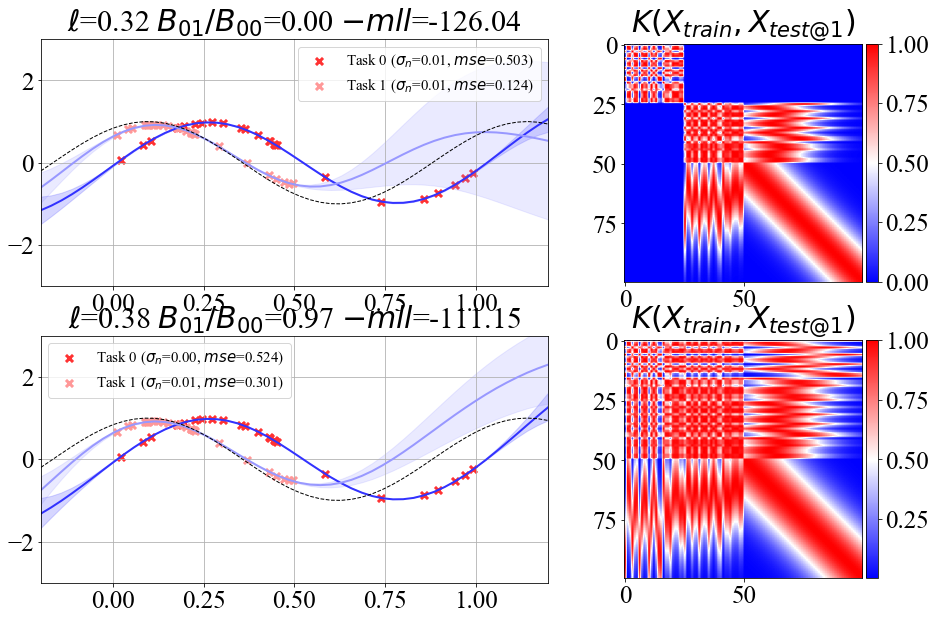

In [22]:

## Plotting

        
def log_func(i, f, params):
    if verbose:
        print(tabulate([[f(params)]+[x.item() if x.size==1 else x for x in list(params.values())]],
                       tablefmt="plain",
                       floatfmt=".3f",
                       headers=['loss']+list(params.keys()) if i == 0 else ()))


colors_b = [cmap(.1), cmap(.3)]
colors_r = [cmap(.9), cmap(.7)]

gridspec_kw = {'width_ratios': [2, 1], 'height_ratios': [1, 1]}
fig, axs = plt.subplots(2, 2, gridspec_kw=gridspec_kw)
fig.set_size_inches(15, 10)


for i, mtl in enumerate([False, True]):
    ax = axs[i, 0]
    
    def get_mtgp_Lv(params):
        if mtl:
            return np.exp(params['logL']), np.exp(params['logv'])
        else:
            return np.log(np.zeros((M,1))), np.log(np.ones((M,)))

    ## Training
    
    def nmll(params):
        logL, logv = get_mtgp_Lv(params)
        k = lambda X, Y: mtgp_k(X, Y, logℓ=params['logℓ'], logL=logL, logv=logv)
        μ, Σ, mll = gp_regression_chol(
            X_train, y_train, X_test, k, logsn=params['logsn'])
        return -mll
    params = {'logℓ': np.log(1.),
              'logsn': np.log(.1*np.ones(M)),
              'logL': np.log(np.array(random.uniform(key,(M,M)))),
              'logv': np.log(np.ones((M,1)))}
    res = run_sgd(nmll, params, lr=lr, num_steps=num_steps, optimizer=opt, log_func=log_func)
    logℓ, logsn = res['logℓ'].item(), res['logsn']
    ℓ, σn = np.exp(logℓ), np.exp(logsn)
    logL, logv = get_mtgp_Lv(params)
    L = np.exp(logL); v = np.exp(logv)
    B = L@L.T + np.diag(v)

    ## Plotting

    k = lambda X, Y: mtgp_k(X, Y, logℓ, logL, logv)
    μ, Σ, mll = gp_regression_chol(X_train, y_train, X_test, k, logsn)
    std = np.expand_dims(np.sqrt(np.diag(Σ)), 1)

    for t in range(M):
        # task-specific mll
        I = X_test[:,1] == t
        # posterior predictive distribution
        X_test_, μ_, std_ = X_test[I,0].squeeze(), μ[I].squeeze(), std[I].squeeze()
        ax.plot(X_test_, μ_, color=colors_b[t], lw=2)
        ax.fill_between(X_test_, μ_-2*std_, μ_+2*std_, alpha=.2, color=colors_b[t])
        # generating function for main task
        if t == 1:
            ax.plot(X_test_, fs[t](X_test_), color='k', linestyle='dashed', linewidth=1)
        
        mse = mean_squared_error(μ[I], f1(X_test[I,0]))
        # train data points
        I = X_train[:,1] == t
        ax.scatter(X_train[I,0], y_train[I],
                   marker='x', color=colors_r[t], s=50,
                   label=f'Task {t}'+' ($\sigma_n$'+f'={σn[t]:.2f}, '+'$mse$'+f'={mse:.3f})')
        
    ax.grid()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(fontsize=15)
    title = '$\ell$'+f'={ℓ:.2f}'+ \
        ' $B_{01}/B_{00}$'+f'={B[0,1]*2/(B[0,0]+B[1,1]):.2f}'+ \
        ' $-mll$'+f'={-mll:.2f}'
    ax.set_title(title, fontsize=30)
    

    ax = axs[i, 1]
    XX = np.vstack((X_train, X_test[X_test[:,1]==1]))
    K = k(XX, XX)
    im = ax.imshow(normalize_K(K), cmap=cmap)
    fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
    ax.set_title('$K(X_{train}, X_{test@1})$')
    

# fig.tight_layout()
# plt_savefig(fig, 'summary/assets/plt_mtgp.png')